In [136]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.optimize import curve_fit

## To Do
#### different Pr1s for different A_Ca.

In [137]:
def sim(seed,spike_train,A_Ca,N_0,Pr1):
    random.seed(seed)
    
    release=np.zeros(len(spike_train),dtype=np.bool)

    #N_0=10
    #Pr1=0.0744
    alpha_0=-np.log((1-Pr1))/N_0

    #Cs=np.array([0.9,0.95,0.8])
    Cs=np.array([0.9,0.95,0.8])
    k=-np.log(Cs)/A_Ca
    Cs=np.exp(-20e-6*k)
    
    tau_f=np.array([35,190,2000])/1000
    tau_d=2

    Fs=np.zeros((len(spike_train),3))
    F=np.ones(len(spike_train))
    N=np.zeros(len(spike_train))
    alpha_v=np.ones(len(spike_train))
    Pr=np.ones(len(spike_train))
    

    alpha_v[0]=alpha_0
    Fs[0,:]=np.ones(3)
    N[0]=N_0
    Pr[0]=Pr1

    for i,t in enumerate(spike_train[:-1]):
        Fs[i+1,:]=1+Cs*np.exp(-(spike_train[i+1]-spike_train[i])/tau_f)*Fs[i,:]
        F[i+1]=np.prod(Fs[i+1,:])
        alpha_v[i+1]=alpha_0*F[i+1]

        #print(alpha_v[i],N[i])

        u=random.uniform(0,1)
        r=random.uniform(0,1)
        N[i+1]=N[i]
        if u < Pr[i]:
            N[i+1]=N[i+1]-1
            release[i]+=1
        if r < 1-np.exp(-(spike_train[i+1]-spike_train[i])/tau_d) and N[i+1]<N_0:
            N[i+1]=N[i+1]+1

        #vesicle release probability
        Pr[i+1]=1-np.exp(-alpha_v[i+1]*N[i+1])

    return alpha_v,N,Pr,release

In [138]:
#C,V,release=sim()
def run(A_Ca=8e-6,N_0=10,Pr1=0.0744):
    #T=np.linspace(0,2,1001)
    spike_train=np.array([0.0022, 0.0522, 0.1022, 0.1522, 0.2023, 0.2522, 0.3021, 0.3522,
           0.4022, 0.4522, 0.5022, 0.5523, 0.6022, 0.6522, 0.7023, 0.7522,
           0.8022, 0.8522, 0.9022, 0.9522]) #,10,20,30,40,50,60,70


    N=500
    
    with Pool(8) as P:
        alpha_vs,Ns,Prs,releases=zip(*P.starmap(sim,zip(range(N),N*[spike_train],N*[A_Ca],N*[N_0],N*[Pr1])))
    Pr=np.average(np.array(Prs),axis=0)
    release=np.average(np.array(releases),axis=0)
    N=np.average(np.array(Ns),axis=0)
    alpha_v=np.average(np.array(alpha_vs),axis=0)
    #spike_train=np.average(np.array(spike_trains),axis=0)
    return Pr,release,N,alpha_v,spike_train

#Pr,release,N,alpha_v,spike_train=run(8e-6)

Text(0.5, 1.0, 'Pr')

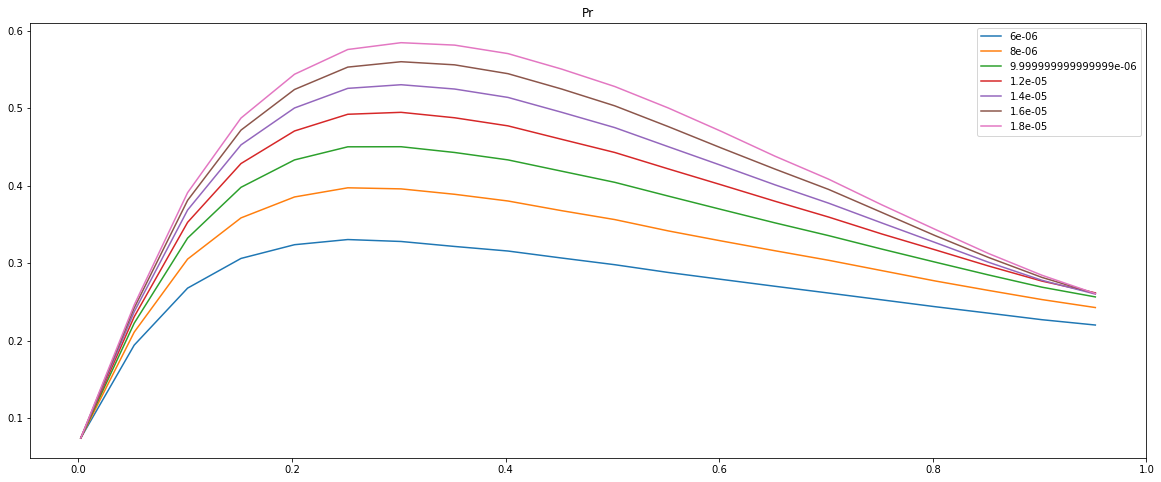

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(20,8))

for i in range(6,20,2):
    A_Ca=i*1e-6
    Pr,release,N,alpha_v,spike_train=run(A_Ca=A_Ca)
    #print(len(Pr),len(spike_train))
    ax.plot(spike_train,Pr,label=str(A_Ca))
    
ax.legend()
ax.set_title("Pr")

Text(0.5, 1.0, 'Pr')

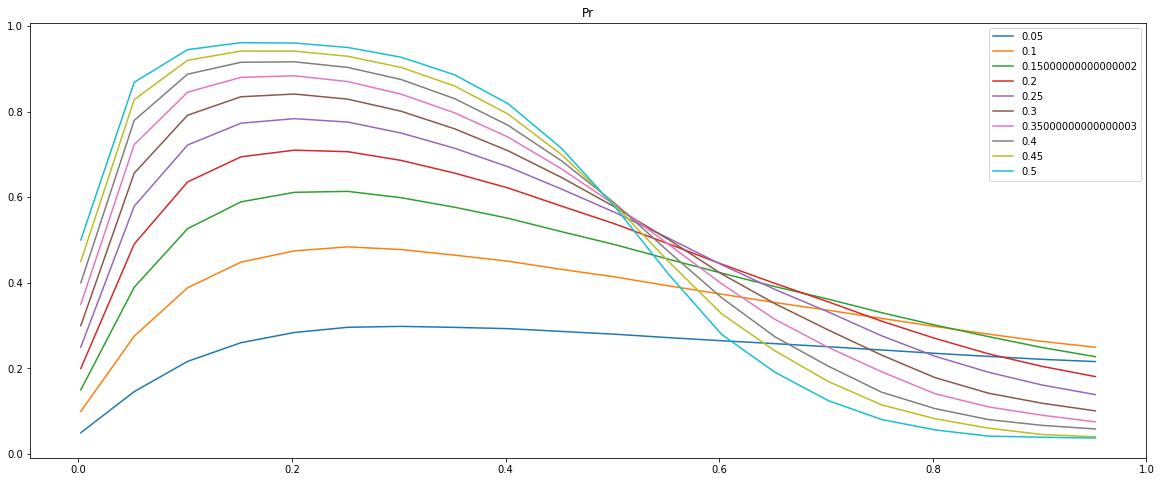

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(20,8))

for Pr1 in np.linspace(0.05,0.5,10):
    A_Ca=15e-6
    Pr,release,N,alpha_v,spike_train=run(Pr1=Pr1)
    
    ax.plot(spike_train,Pr,label=str(Pr1))
    
ax.legend()
ax.set_title("Pr")

NameError: name 'fnames' is not defined

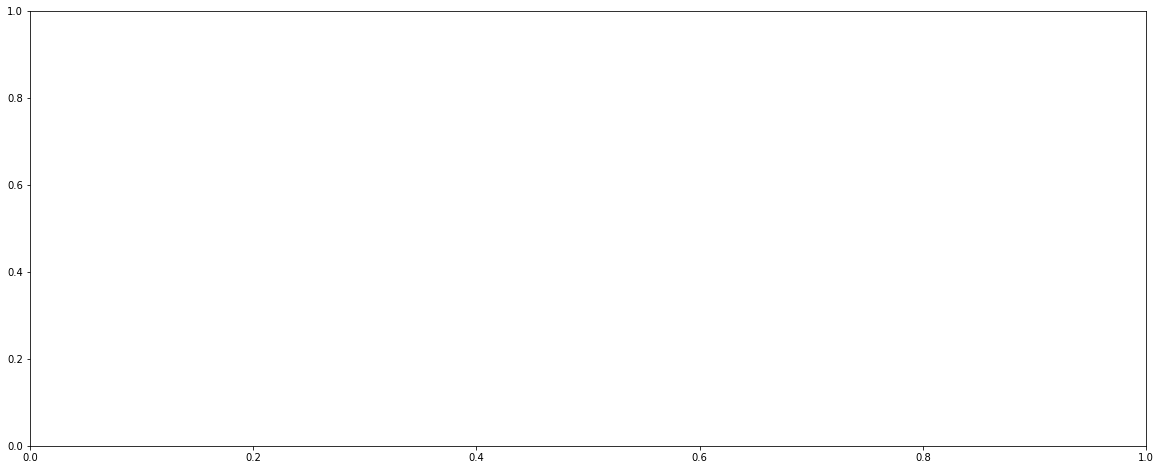

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(20,8))

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

for sim_type,c in zip(fnames,cpalette):
    A_Ca=15e-6
    Pr,release,N,alpha_v,spike_train=run(A_Ca=A_Ca,Pr1=data[sim_type].T[1][0])
    ax.plot(spike_train,Pr,'.-',color=c)
    ax.plot(spike_train,data[sim_type].T[1],label=sim_type,color=c)
    
ax.legend()

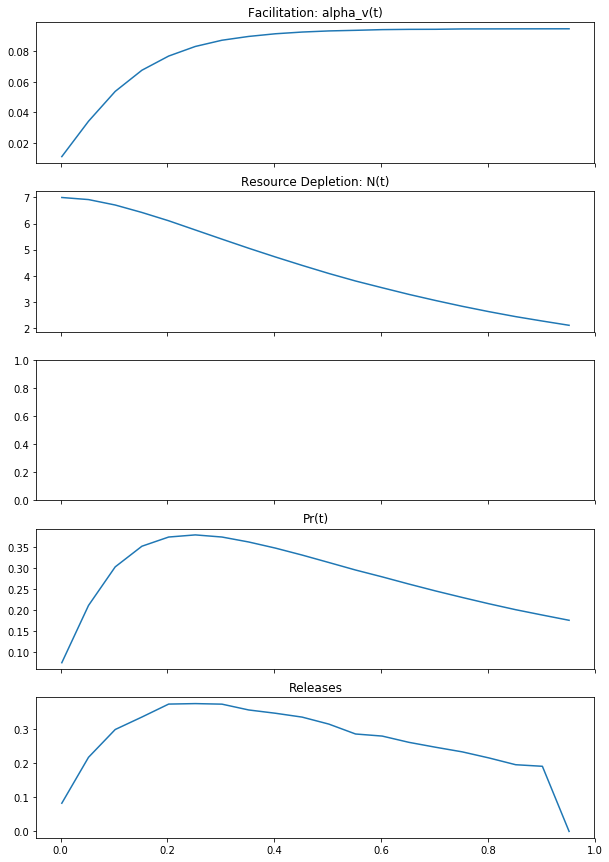

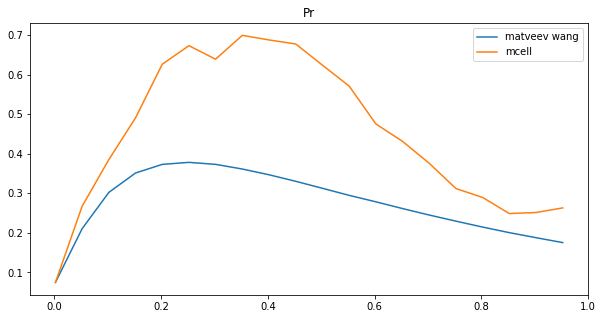

In [41]:
fig, ax = plt.subplots(nrows=5,ncols=1,sharex=True,figsize=(10,15))

ax[0].plot(spike_train,alpha_v)
ax[0].set_title("Facilitation: alpha_v(t)")

ax[1].plot(spike_train,N)
ax[1].set_title("Resource Depletion: N(t)")

#ax[2].plot(T,beta)
#ax[2].set_title("ER Depletion: beta(t)")

ax[3].plot(spike_train,Pr)
ax[3].set_title("Pr(t)")

ax[4].plot(spike_train,release)
ax[4].set_title("Releases")


fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(10,5))

ax.plot(spike_train,Pr,label="matveev wang")
ax.set_title("Pr")

ax.plot(spike_train,data["R150control20hz"].T[1],label="mcell")

ax.legend()

## Loading mcell results

In [4]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
peaks={}

fnames=["R150control20hz","R150ER2x20hz","R150ER3x20hz","R300ER2x20hz","R300ER3x20hz"] #,"R150ER2x20hz" "R150ER3x20hz"
for sim_type in fnames:
    loc=res_loc+sim_type+"/result"
    print(loc)
    data[sim_type]=np.loadtxt(loc)
    peaks[sim_type]=np.loadtxt(res_loc+sim_type+"/caStat.dat").T[1]

/home/kabir/Project/tripartiteSynapse/results/freq/R150control20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER3x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/result


In [101]:
#plt.plot(spike_train,data["R150control20hz"].T[1])
#data["R150control20hz"].T[1]

In [102]:
#peaks["R300ER3x20hz"]

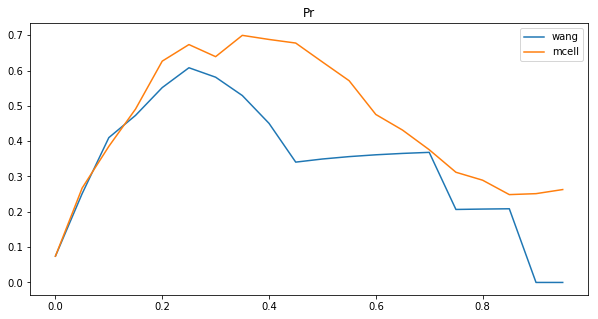

In [53]:
#input spike times
spike_train=np.array(range(20))/20
release=np.zeros(10,dtype=np.bool)

N_0=7
Pr1=0.0744
alpha_0=-np.log((1-Pr1))/N_0

Cs=np.array([0.9,0.95,0.8])
tau_f=np.array([35,190,2000])/1000
tau_d=2

Fs=np.zeros((len(spike_train),3))
F=np.ones(len(spike_train))
N=np.zeros(len(spike_train))
alpha_v=np.ones(len(spike_train))
Pr=np.ones(len(spike_train))

alpha_v[0]=alpha_0
Fs[0,:]=np.ones(3)
N[0]=N_0
Pr[0]=Pr1

for i,t in enumerate(spike_train[:-1]):
    Fs[i+1,:]=1+Cs*np.exp(-(spike_train[i+1]-spike_train[i])/tau_f)*Fs[i,:]
    F[i+1]=np.prod(Fs[i+1,:])
    alpha_v[i+1]=alpha_0*F[i+1]
    
    #print(alpha_v[i],N[i])
    
    u=random.uniform(0,1)
    r=random.uniform(0,1)
    N[i+1]=N[i]
    if u < Pr[i]:
        N[i+1]=N[i+1]-1
    if r < 1-np.exp(-(spike_train[i+1]-spike_train[i])/tau_d) and N[i+1]<N_0:
        N[i+1]=N[i+1]+1
        
    #vesicle release probability
    Pr[i+1]=1-np.exp(-alpha_v[i+1]*N[i+1])
    
    
    

fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(10,5))

ax.plot(spike_train,Pr,label="wang")
ax.set_title("Pr")

ax.plot(spike_train,data["R150control20hz"].T[1],label="mcell")

ax.legend()

In [21]:
A_Ca=8e-6
Cs=np.array([0.9,0.95,0.8])
k=-np.log(Cs)/A_Ca

In [22]:
Cs_AD=np.exp(-14e-6*k)

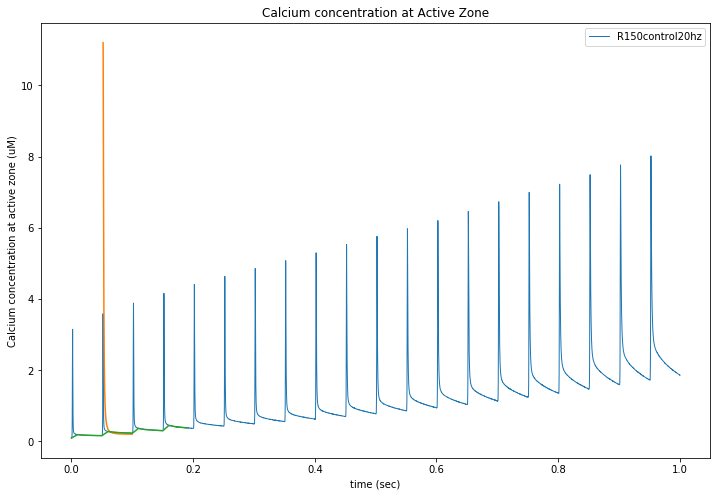

In [418]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]

for name in fnames:
    #name="R150ER2x20hz"
    #loc=res_loc+'/'+name.replace(".mdl","")+'/'+'CaConc'
    loc=res_loc+name.replace(".mdl","")+'/'+'ca.dat'
    data[name]=np.loadtxt(loc)
    
plt.figure(figsize=(12,8))

#for i,name in enumerate(fnames):
name=fnames[0]
xdata=data[name].T[0]#+i/150
ydata=data[name].T[2]/602.3
plt.plot(xdata,ydata,label=name,lw='1')

def func1(x,A,t1,t2,t3,C,D):
    return A*np.exp(-x**3/t1-x**2/t2-x/t3+C)+D
    #return A*x+tau
    
def func3(x,A,t1,t2,C,D):
    return A*np.exp(-x**2/t1-x/t2+C)+D    
    
def func2(x,A,B,D,t1,t2):
    return A*np.exp(-x/t1)+B*np.exp(-x/t2) + D#+C*np.exp(-x/t3)+D

def func4(x,t1,t2):
    A=8.683716
    D=0.2
    y=x-0.00225
    return A*np.exp(-y**2/t1-y/t2)+D  

def func5(x,t1,t2):
    A=np.log(11.033626)
    D=np.log(0.2)
    y=x-0.05225
    return A*np.exp(-y**2/t1-y/t2)+D

def func6(x,B):
    y=x-0.05225
    A=11.033626
    return A*(1-np.tanh(B*y))+0.2

def func7(x,A,B):
    return A*np.exp(-B*y)

def func8(x,B):
    y=x-0.05225
    return 11/(1+B*y**2)+ 0.2

l,u=0.06,0.1  #0.0022
a = np.argmin(np.abs(xdata - l))
b = np.argmin(np.abs(xdata - u))



opt=curve_fit(func8,xdata[a:b],ydata[a:b],p0=(1))#,0.1,0.1))
#opt[0]=[8,1,2,0.005,1]
#opt=[4.08348196e+01, 2.92918959e-06, 3.75318305e-01]

#p=np.polyfit(xdata[a:b],ydata[a:b],3)

x_plot=np.linspace(0.05225,0.1,5000)
y_plot=func8(x_plot,*opt[0])#np.polyval(p,x_plot)
plt.plot(x_plot,y_plot)

plt.xlabel("time (sec)")
plt.ylabel("Calcium concentration at active zone (uM)")
plt.title("Calcium concentration at Active Zone")

#plt.ylim((8,10))
#plt.xlim((0.00,0.005))

#plt.ylim((8,14))
#plt.xlim((0.05,0.055))

#plt.ylim((12,16))
#plt.xlim((0.1,0.105))

#plt.xlim((0,0.1)) #.00212
#plt.xlim((0.05,0.09))

plt.plot(xdata[ca_peak_args],ydata[ca_peak_args])

plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/aztrain20hz.eps")


In [335]:
spike_train=np.array([0.0022, 0.0522, 0.1022, 0.1522, 0.2023, 0.2522, 0.3021, 0.3522,
           0.4022, 0.4522, 0.5022, 0.5523, 0.6022, 0.6522, 0.7023, 0.7522,
           0.8022, 0.8522, 0.9022, 0.9522])
ca_peak_args=np.zeros(len(spike_train),dtype='int')
for i,t in enumerate(spike_train):
    spike_arg=np.argmin(np.abs(t-xdata))
    ca_peak_args[i]=np.argmax(ydata[0:spike_arg+100])

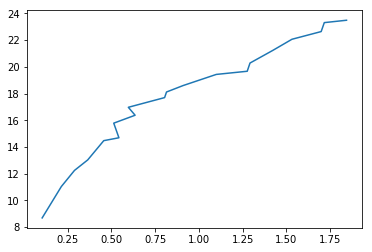

In [415]:
ls=np.arange(0,1,0.05)+0.01
us=np.arange(0,1,0.05)#+0.05
inc=[]
bs=[]
for i,arg in enumerate(ca_peak_args):
    l,u=ls[i],us[i]
    a = np.argmin(np.abs(xdata - l))
    b = np.argmin(np.abs(xdata - u))
    bs.append(ydata[b])
    inc.append(ydata[arg])
    #opt=curve_fit(func8,xdata[a:b],ydata[a:b],p0=(1))
plt.plot(bs,inc)

In [309]:
np.set_printoptions(precision=4)
#func4(0.0022,*opt[0])
opt[0]

array([220.8884])

In [ ]:
m=np.argmax(ydata[0:2000])
print(m,xdata[m],ydata[m])

#### $Ae^{-\frac{x^3}{\tau_1}-\frac{x^2}{\tau_2}-\frac{x}{\tau_3}+C}+D$
#### $A,\tau_1,\tau_2,\tau_3,C,D$=[ 7.20948438e-01, -9.74289429e+03,  2.23271170e+03,  6.77627018e-03,2.31041226e-01]


#### $Ae^{-\frac{x^2}{\tau_1}-\frac{x}{\tau_2}+C}+D$
#### $A,\tau_1,\tau_2,C,D$=[2.2595e-01 2.1485e+02 6.7762e-03 1.1603e+00 2.3104e-01]

#### $Ae^{-\frac{x}{\tau_1}}+Be^{-\frac{x}{\tau_2}}+D$
#### $A,B,D,\tau_1,\tau_2$=[ 1.0710e+01, -4.7463e+03,  4.7468e+03,  4.6641e-04, -6.2965e+02]

#### $8e^{-\frac{x^2}{\tau_1}-\frac{x}{\tau_2}}+0.02$ 
#### $\tau_1,\tau_2$=[6.5765e+02, 1.2177e-03] ,[8.7754e+02, 9.0346e-04]

In [211]:
spike_train=np.array([0.0022, 0.0522, 0.1022, 0.1522, 0.2023, 0.2522, 0.3021, 0.3522,
           0.4022, 0.4522, 0.5022, 0.5523, 0.6022, 0.6522, 0.7023, 0.7522,
           0.8022, 0.8522, 0.9022, 0.9522]) #,10,20,30,40,50,60,70
tau=3e-6
x_0=8
delta_x=1
x=np.zeros(len(spike_train))
x[0]=x_0+0.2

In [214]:
for i in range(len(spike_train)-1):
    #x[i+1]=(x[i]-0)*np.exp(-(spike_train[i+1]-spike_train[i])/tau)+x_0
    x[i+1]=(x[i]-0.2)*np.exp(-(spike_train[i+1]-spike_train[i])/tau)+x_0

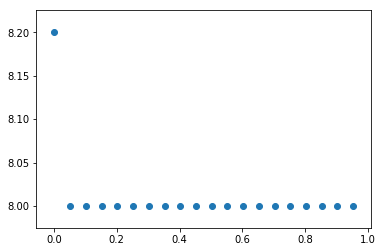

In [215]:
plt.scatter(spike_train,x)